In [1]:
!pip -q install pyshp
!pip -q install influxdb
!pip -q install shapely
!pip -q install ipyleaflet
!pip -q install plotly

In [2]:
import shapefile
import pandas as pd
import pandas as pd
import seaborn as sns
import tarfile
from datetime import datetime
from six.moves import urllib
from shapely.geometry import Point
from dotenv import load_dotenv
import numpy as np
import json
from influxdb import DataFrameClient
from shapely.geometry import Point, Polygon
from ipyleaflet import Map, GeoJSON, basemaps, Polyline, Heatmap
import requests
from datetime import datetime, timedelta

In [3]:
variable = "temperature"

In [4]:
def rm_outside_polygon(res_pd_frame,polygon):
    res_pd_frame_1 = res_pd_frame[['lon','lat','sensor_id']]
    res_pd_frame_2 = res_pd_frame_1.reset_index()
    res_pd_frame_3 = res_pd_frame_2.drop(columns=['index'])
    res_pd_frame4 = res_pd_frame_3.drop_duplicates()
    res_pd_frame4["polygon1"] = res_pd_frame4.apply(lambda row: Polygon(poly).intersects(Point(row["lon"], row["lat"])), axis = 1)
    res_pd_frame5 = res_pd_frame4.drop(res_pd_frame4[res_pd_frame4["polygon1"]].index)
    res_pd_frame = res_pd_frame[~res_pd_frame.sensor_id.isin(res_pd_frame5.sensor_id)]     
    return res_pd_frame

In [5]:
#sf = shapefile.Reader("landkreise-in-germany.shp") # This is Göttingen
#s = sf.shape(0)

sf = shapefile.Reader("bundesland.shp") # Complete germany, 16 shapes for each bundesland
s = sf.shape(3) # Baden-Württemberg
poly = Polygon(s.points)  # Convert to polygon to use shapely function point.within(polygon)

geo_json = GeoJSON(data=s.__geo_interface__, style = {'color': 'red', 'opacity':1, 'weight':1.9, 'dashArray':'9', 'fillOpacity':0.1})

In [6]:
def main(host=os.getenv("HOST"), port=os.getenv("PORT"), rectangle=[0,0,0,0],time_range=["",""],limit=100):
    """Instantiate the connection to the InfluxDB client."""
    user = os.getenv("USER")
    password = os.getenv("PASSWORD")
    dbname = os.getenv("DB")
    protocol = 'line'

    client = DataFrameClient(host, port, user, password, dbname, ssl=True, verify_ssl=True)

    bind_params = {
        "start_time_epoch": time_range[0],
        "end_time_epoch": time_range[1]
    }
    
    measurement = variable + ", lat, lon, sensor_id"
    
    query = f"select {measurement} from sensor where \
                     time > $start_time_epoch AND \
                     time < $end_time_epoch AND \
                     lon > {rectangle[0]} AND \
                     lon < {rectangle[2]} AND \
                     lat > {rectangle[1]} AND \
                     lat < {rectangle[3]} \
                     limit {limit}"
                
    res=client.query(query, bind_params=bind_params)
    return res

In [7]:
m = Map(center=(48.7,9.8,0 ), zoom=8, basemap=basemaps.Hydda.Full)
m.add_layer(geo_json)

In [8]:
start_date = datetime(2017, 1, 2)
end_date = start_date + timedelta(hours=1)

appended_res_pd_frame_plot_timeindex = []

j = 0
for i in range(0,24):
    time_range=[start_date.strftime("%Y-%m-%dT%H:%M:%SZ"),end_date.strftime("%Y-%m-%dT%H:%M:%SZ")]
    print(time_range)
    
    res=main(rectangle=s.bbox,time_range=time_range,limit=10000)
    
    res_pd_frame=rm_outside_polygon(res['sensor'],poly)
    
    if variable in res_pd_frame.keys():
            res_pd_frame.dropna(subset=[variable],inplace = True)
    
    res_pd_frame_drop = res_pd_frame.drop(['lat', 'lon'], axis = 1)

    res_pd_frame_mean = res_pd_frame_drop.groupby(['sensor_id'],as_index=True)[variable].mean()

    res_pd_frame_mean = res_pd_frame_mean.to_frame()
    
    res_pd_frame_plot = res_pd_frame_mean.swapaxes("index", "columns") 
    res_pd_frame_plot_timeindex = res_pd_frame_plot.rename(index={variable: start_date})
    res_pd_frame_plot_timeindex
    
    appended_res_pd_frame_plot_timeindex.append(res_pd_frame_plot_timeindex)

    start_date=end_date
    end_date=start_date + timedelta(hours=1)

appended_res_pd_frame_plot_timeindex = pd.concat(appended_res_pd_frame_plot_timeindex)
appended_res_pd_frame_plot_timeindex.index.name = 'timestamp'
appended_res_pd_frame_plot_timeindex

['2017-01-02T00:00:00Z', '2017-01-02T01:00:00Z']


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


['2017-01-02T01:00:00Z', '2017-01-02T02:00:00Z']
['2017-01-02T02:00:00Z', '2017-01-02T03:00:00Z']
['2017-01-02T03:00:00Z', '2017-01-02T04:00:00Z']
['2017-01-02T04:00:00Z', '2017-01-02T05:00:00Z']
['2017-01-02T05:00:00Z', '2017-01-02T06:00:00Z']
['2017-01-02T06:00:00Z', '2017-01-02T07:00:00Z']
['2017-01-02T07:00:00Z', '2017-01-02T08:00:00Z']
['2017-01-02T08:00:00Z', '2017-01-02T09:00:00Z']
['2017-01-02T09:00:00Z', '2017-01-02T10:00:00Z']
['2017-01-02T10:00:00Z', '2017-01-02T11:00:00Z']
['2017-01-02T11:00:00Z', '2017-01-02T12:00:00Z']
['2017-01-02T12:00:00Z', '2017-01-02T13:00:00Z']
['2017-01-02T13:00:00Z', '2017-01-02T14:00:00Z']
['2017-01-02T14:00:00Z', '2017-01-02T15:00:00Z']
['2017-01-02T15:00:00Z', '2017-01-02T16:00:00Z']
['2017-01-02T16:00:00Z', '2017-01-02T17:00:00Z']
['2017-01-02T17:00:00Z', '2017-01-02T18:00:00Z']
['2017-01-02T18:00:00Z', '2017-01-02T19:00:00Z']
['2017-01-02T19:00:00Z', '2017-01-02T20:00:00Z']
['2017-01-02T20:00:00Z', '2017-01-02T21:00:00Z']
['2017-01-02T21:00:0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,131,154,160,161,163,176,190,194,198,204,...,298,306,316,332,336,340,342,362,71,84
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-02 00:00:00,-1.432609,0.100000,-3.280556,NaN,-1.856604,-2.521951,-0.938462,-3.775000,-4.300000,-4.054098,...,-0.688333,-5.475000,-2.891489,-0.592308,NaN,0.528125,25.6,NaN,-2.480769,-3.600971
2017-01-02 01:00:00,-1.115217,0.137931,-2.713043,NaN,-1.638298,-2.586047,-0.685455,-3.605660,-4.143860,-4.563934,...,-0.796825,-5.159016,-2.365385,-0.566667,NaN,0.744444,NaN,NaN,-2.167961,-3.257843
2017-01-02 02:00:00,-0.997674,0.512121,-2.487234,NaN,-1.750980,-2.965116,-0.512727,-3.500000,-3.921053,-5.050000,...,-0.745161,-4.814754,-2.181250,-0.830769,NaN,2.300000,NaN,NaN,-1.923529,-2.982692
2017-01-02 03:00:00,-1.007500,0.636842,-2.248837,NaN,-1.641304,-3.070000,-0.464000,-3.319608,-3.790741,-4.796774,...,-0.308197,-4.787097,-1.887273,-0.916667,NaN,1.567647,NaN,NaN,-1.763366,-2.833654
2017-01-02 04:00:00,-0.992857,0.656000,-2.123684,NaN,-1.566129,-2.995122,-0.307273,-3.200000,-3.480000,-3.179032,...,0.268254,-4.416393,-1.697917,-1.007143,NaN,1.781481,NaN,NaN,-1.767000,-2.787500
2017-01-02 05:00:00,-1.000000,0.479310,-1.991667,NaN,-1.577419,-2.821951,-0.316981,-3.106250,-3.732075,-2.377778,...,0.442623,-4.632203,-1.820408,-0.684615,-2.309615,1.882143,NaN,NaN,-1.648039,-2.878846
2017-01-02 06:00:00,-1.210638,0.356667,-1.976190,NaN,-1.583871,-2.659524,0.096078,-2.829630,-3.720000,-2.288136,...,0.591935,-4.314516,-1.763830,-0.629412,-2.378333,2.340741,NaN,NaN,-1.371569,-3.004808
2017-01-02 07:00:00,-0.729787,0.726923,-1.851163,NaN,-1.224194,-2.530769,0.032075,-2.335849,-3.862963,-0.603390,...,1.063492,-4.252459,-1.216667,-0.316667,-2.145763,2.244444,NaN,NaN,-1.574510,-2.575248
2017-01-02 08:00:00,0.085106,1.475000,-1.389744,NaN,-0.566129,-1.853488,0.330189,-1.621818,-1.466102,2.257627,...,1.512903,-3.583871,-0.298039,0.357895,-1.857143,1.465714,NaN,NaN,-1.334000,-1.833654


In [9]:
appended_res_pd_frame_plot_timeindex_index = appended_res_pd_frame_plot_timeindex.reset_index()
appended_res_pd_frame_plot_timeindex_index

,timestamp,131,154,160,161,163,176,190,194,198,...,298,306,316,332,336,340,342,362,71,84
0,2017-01-02 00:00:00,-1.432609,0.100000,-3.280556,NaN,-1.856604,-2.521951,-0.938462,-3.775000,-4.300000,...,-0.688333,-5.475000,-2.891489,-0.592308,NaN,0.528125,25.6,NaN,-2.480769,-3.600971
1,2017-01-02 01:00:00,-1.115217,0.137931,-2.713043,NaN,-1.638298,-2.586047,-0.685455,-3.605660,-4.143860,...,-0.796825,-5.159016,-2.365385,-0.566667,NaN,0.744444,NaN,NaN,-2.167961,-3.257843
2,2017-01-02 02:00:00,-0.997674,0.512121,-2.487234,NaN,-1.750980,-2.965116,-0.512727,-3.500000,-3.921053,...,-0.745161,-4.814754,-2.181250,-0.830769,NaN,2.300000,NaN,NaN,-1.923529,-2.982692
3,2017-01-02 03:00:00,-1.007500,0.636842,-2.248837,NaN,-1.641304,-3.070000,-0.464000,-3.319608,-3.790741,...,-0.308197,-4.787097,-1.887273,-0.916667,NaN,1.567647,NaN,NaN,-1.763366,-2.833654
4,2017-01-02 04:00:00,-0.992857,0.656000,-2.123684,NaN,-1.566129,-2.995122,-0.307273,-3.200000,-3.480000,...,0.268254,-4.416393,-1.697917,-1.007143,NaN,1.781481,NaN,NaN,-1.767000,-2.787500
5,2017-01-02 05:00:00,-1.000000,0.479310,-1.991667,NaN,-1.577419,-2.821951,-0.316981,-3.106250,-3.732075,...,0.442623,-4.632203,-1.820408,-0.684615,-2.309615,1.882143,NaN,NaN,-1.648039,-2.878846
6,2017-01-02 06:00:00,-1.210638,0.356667,-1.976190,NaN,-1.583871,-2.659524,0.096078,-2.829630,-3.720000,...,0.591935,-4.314516,-1.763830,-0.629412,-2.378333,2.340741,NaN,NaN,-1.371569,-3.004808
7,2017-01-02 07:00:00,-0.729787,0.726923,-1.851163,NaN,-1.224194,-2.530769,0.032075,-2.335849,-3.862963,...,1.063492,-4.252459,-1.216667,-0.316667,-2.145763,2.244444,NaN,NaN,-1.574510,-2.575248
8,2017-01-02 08:00:00,0.085106,1.475000,-1.389744,NaN,-0.566129,-1.853488,0.330189,-1.621818,-1.466102,...,1.512903,-3.583871,-0.298039,0.357895,-1.857143,1.465714,NaN,NaN,-1.334000,-1.833654
9,2017-01-02 09:00:00,0.540541,2.193548,-0.742222,NaN,0.188889,-0.804762,1.092727,-1.190909,1.252727,...,2.174194,-1.306000,-0.184314,1.066667,-1.070175,1.642857,NaN,NaN,-0.744554,-0.980769


In [10]:
df = appended_res_pd_frame_plot_timeindex_index.melt('timestamp', var_name='sensor_ids',value_name=variable) 
df['timestamp'] = df['timestamp'].apply(lambda x: x.strftime('%Y-%m-%d \n %H:%M:%S'))
df

,timestamp,sensor_ids,temperature
0,2017-01-02 \n 00:00:00,131,-1.432609
1,2017-01-02 \n 01:00:00,131,-1.115217
2,2017-01-02 \n 02:00:00,131,-0.997674
3,2017-01-02 \n 03:00:00,131,-1.007500
4,2017-01-02 \n 04:00:00,131,-0.992857
...,...,...,...
835,2017-01-02 \n 19:00:00,84,-0.237500
836,2017-01-02 \n 20:00:00,84,-0.142105
837,2017-01-02 \n 21:00:00,84,-0.319231
838,2017-01-02 \n 22:00:00,84,-0.273077


In [11]:
gb = df.groupby('sensor_ids')    
a = [gb.get_group(x) for x in gb.groups]
a

a[0]

,timestamp,sensor_ids,temperature
0,2017-01-02 \n 00:00:00,131,-1.432609
1,2017-01-02 \n 01:00:00,131,-1.115217
2,2017-01-02 \n 02:00:00,131,-0.997674
3,2017-01-02 \n 03:00:00,131,-1.007500
4,2017-01-02 \n 04:00:00,131,-0.992857
5,2017-01-02 \n 05:00:00,131,-1.000000
6,2017-01-02 \n 06:00:00,131,-1.210638
7,2017-01-02 \n 07:00:00,131,-0.729787
8,2017-01-02 \n 08:00:00,131,0.085106
9,2017-01-02 \n 09:00:00,131,0.540541


,timestamp,sensor_ids,temperature
0,2017-01-02 \n 00:00:00,131,-1.432609
1,2017-01-02 \n 01:00:00,131,-1.115217
2,2017-01-02 \n 02:00:00,131,-0.997674
3,2017-01-02 \n 03:00:00,131,-1.007500
4,2017-01-02 \n 04:00:00,131,-0.992857
5,2017-01-02 \n 05:00:00,131,-1.000000
6,2017-01-02 \n 06:00:00,131,-1.210638
7,2017-01-02 \n 07:00:00,131,-0.729787
8,2017-01-02 \n 08:00:00,131,0.085106
9,2017-01-02 \n 09:00:00,131,0.540541


,timestamp,sensor_ids,temperature
24,2017-01-02 \n 00:00:00,154,0.100000
25,2017-01-02 \n 01:00:00,154,0.137931
26,2017-01-02 \n 02:00:00,154,0.512121
27,2017-01-02 \n 03:00:00,154,0.636842
28,2017-01-02 \n 04:00:00,154,0.656000
29,2017-01-02 \n 05:00:00,154,0.479310
30,2017-01-02 \n 06:00:00,154,0.356667
31,2017-01-02 \n 07:00:00,154,0.726923
32,2017-01-02 \n 08:00:00,154,1.475000
33,2017-01-02 \n 09:00:00,154,2.193548


,timestamp,sensor_ids,temperature
48,2017-01-02 \n 00:00:00,160,-3.280556
49,2017-01-02 \n 01:00:00,160,-2.713043
50,2017-01-02 \n 02:00:00,160,-2.487234
51,2017-01-02 \n 03:00:00,160,-2.248837
52,2017-01-02 \n 04:00:00,160,-2.123684
53,2017-01-02 \n 05:00:00,160,-1.991667
54,2017-01-02 \n 06:00:00,160,-1.976190
55,2017-01-02 \n 07:00:00,160,-1.851163
56,2017-01-02 \n 08:00:00,160,-1.389744
57,2017-01-02 \n 09:00:00,160,-0.742222


,timestamp,sensor_ids,temperature
72,2017-01-02 \n 00:00:00,161,NaN
73,2017-01-02 \n 01:00:00,161,NaN
74,2017-01-02 \n 02:00:00,161,NaN
75,2017-01-02 \n 03:00:00,161,NaN
76,2017-01-02 \n 04:00:00,161,NaN
77,2017-01-02 \n 05:00:00,161,NaN
78,2017-01-02 \n 06:00:00,161,NaN
79,2017-01-02 \n 07:00:00,161,NaN
80,2017-01-02 \n 08:00:00,161,NaN
81,2017-01-02 \n 09:00:00,161,NaN


,timestamp,sensor_ids,temperature
96,2017-01-02 \n 00:00:00,163,-1.856604
97,2017-01-02 \n 01:00:00,163,-1.638298
98,2017-01-02 \n 02:00:00,163,-1.750980
99,2017-01-02 \n 03:00:00,163,-1.641304
100,2017-01-02 \n 04:00:00,163,-1.566129
101,2017-01-02 \n 05:00:00,163,-1.577419
102,2017-01-02 \n 06:00:00,163,-1.583871
103,2017-01-02 \n 07:00:00,163,-1.224194
104,2017-01-02 \n 08:00:00,163,-0.566129
105,2017-01-02 \n 09:00:00,163,0.188889


,timestamp,sensor_ids,temperature
120,2017-01-02 \n 00:00:00,176,-2.521951
121,2017-01-02 \n 01:00:00,176,-2.586047
122,2017-01-02 \n 02:00:00,176,-2.965116
123,2017-01-02 \n 03:00:00,176,-3.070000
124,2017-01-02 \n 04:00:00,176,-2.995122
125,2017-01-02 \n 05:00:00,176,-2.821951
126,2017-01-02 \n 06:00:00,176,-2.659524
127,2017-01-02 \n 07:00:00,176,-2.530769
128,2017-01-02 \n 08:00:00,176,-1.853488
129,2017-01-02 \n 09:00:00,176,-0.804762


,timestamp,sensor_ids,temperature
144,2017-01-02 \n 00:00:00,190,-0.938462
145,2017-01-02 \n 01:00:00,190,-0.685455
146,2017-01-02 \n 02:00:00,190,-0.512727
147,2017-01-02 \n 03:00:00,190,-0.464000
148,2017-01-02 \n 04:00:00,190,-0.307273
149,2017-01-02 \n 05:00:00,190,-0.316981
150,2017-01-02 \n 06:00:00,190,0.096078
151,2017-01-02 \n 07:00:00,190,0.032075
152,2017-01-02 \n 08:00:00,190,0.330189
153,2017-01-02 \n 09:00:00,190,1.092727


,timestamp,sensor_ids,temperature
168,2017-01-02 \n 00:00:00,194,-3.775000
169,2017-01-02 \n 01:00:00,194,-3.605660
170,2017-01-02 \n 02:00:00,194,-3.500000
171,2017-01-02 \n 03:00:00,194,-3.319608
172,2017-01-02 \n 04:00:00,194,-3.200000
173,2017-01-02 \n 05:00:00,194,-3.106250
174,2017-01-02 \n 06:00:00,194,-2.829630
175,2017-01-02 \n 07:00:00,194,-2.335849
176,2017-01-02 \n 08:00:00,194,-1.621818
177,2017-01-02 \n 09:00:00,194,-1.190909


,timestamp,sensor_ids,temperature
192,2017-01-02 \n 00:00:00,198,-4.300000
193,2017-01-02 \n 01:00:00,198,-4.143860
194,2017-01-02 \n 02:00:00,198,-3.921053
195,2017-01-02 \n 03:00:00,198,-3.790741
196,2017-01-02 \n 04:00:00,198,-3.480000
197,2017-01-02 \n 05:00:00,198,-3.732075
198,2017-01-02 \n 06:00:00,198,-3.720000
199,2017-01-02 \n 07:00:00,198,-3.862963
200,2017-01-02 \n 08:00:00,198,-1.466102
201,2017-01-02 \n 09:00:00,198,1.252727


,timestamp,sensor_ids,temperature
216,2017-01-02 \n 00:00:00,204,-4.054098
217,2017-01-02 \n 01:00:00,204,-4.563934
218,2017-01-02 \n 02:00:00,204,-5.050000
219,2017-01-02 \n 03:00:00,204,-4.796774
220,2017-01-02 \n 04:00:00,204,-3.179032
221,2017-01-02 \n 05:00:00,204,-2.377778
222,2017-01-02 \n 06:00:00,204,-2.288136
223,2017-01-02 \n 07:00:00,204,-0.603390
224,2017-01-02 \n 08:00:00,204,2.257627
225,2017-01-02 \n 09:00:00,204,3.081034


,timestamp,sensor_ids,temperature
240,2017-01-02 \n 00:00:00,206,-2.248214
241,2017-01-02 \n 01:00:00,206,-1.545614
242,2017-01-02 \n 02:00:00,206,-1.201754
243,2017-01-02 \n 03:00:00,206,-1.409434
244,2017-01-02 \n 04:00:00,206,-2.486207
245,2017-01-02 \n 05:00:00,206,-0.383333
246,2017-01-02 \n 06:00:00,206,-0.741818
247,2017-01-02 \n 07:00:00,206,-0.441509
248,2017-01-02 \n 08:00:00,206,0.889286
249,2017-01-02 \n 09:00:00,206,1.762745


,timestamp,sensor_ids,temperature
264,2017-01-02 \n 00:00:00,208,NaN
265,2017-01-02 \n 01:00:00,208,NaN
266,2017-01-02 \n 02:00:00,208,NaN
267,2017-01-02 \n 03:00:00,208,NaN
268,2017-01-02 \n 04:00:00,208,NaN
269,2017-01-02 \n 05:00:00,208,-1.355556
270,2017-01-02 \n 06:00:00,208,-1.372549
271,2017-01-02 \n 07:00:00,208,-0.820370
272,2017-01-02 \n 08:00:00,208,-0.029630
273,2017-01-02 \n 09:00:00,208,1.519643


,timestamp,sensor_ids,temperature
288,2017-01-02 \n 00:00:00,222,-1.116949
289,2017-01-02 \n 01:00:00,222,-1.036207
290,2017-01-02 \n 02:00:00,222,-1.101818
291,2017-01-02 \n 03:00:00,222,-1.053704
292,2017-01-02 \n 04:00:00,222,-0.652830
293,2017-01-02 \n 05:00:00,222,-0.145455
294,2017-01-02 \n 06:00:00,222,-0.320370
295,2017-01-02 \n 07:00:00,222,-0.310714
296,2017-01-02 \n 08:00:00,222,0.341176
297,2017-01-02 \n 09:00:00,222,0.920370


,timestamp,sensor_ids,temperature
312,2017-01-02 \n 00:00:00,224,-1.991667
313,2017-01-02 \n 01:00:00,224,-1.994444
314,2017-01-02 \n 02:00:00,224,-1.925926
315,2017-01-02 \n 03:00:00,224,-1.787719
316,2017-01-02 \n 04:00:00,224,-1.793220
317,2017-01-02 \n 05:00:00,224,-1.581818
318,2017-01-02 \n 06:00:00,224,-1.446000
319,2017-01-02 \n 07:00:00,224,-1.034694
320,2017-01-02 \n 08:00:00,224,-0.441509
321,2017-01-02 \n 09:00:00,224,0.108772


,timestamp,sensor_ids,temperature
336,2017-01-02 \n 00:00:00,230,-0.391667
337,2017-01-02 \n 01:00:00,230,-0.264912
338,2017-01-02 \n 02:00:00,230,-0.093103
339,2017-01-02 \n 03:00:00,230,0.196296
340,2017-01-02 \n 04:00:00,230,0.263636
341,2017-01-02 \n 05:00:00,230,0.169643
342,2017-01-02 \n 06:00:00,230,0.329825
343,2017-01-02 \n 07:00:00,230,0.811667
344,2017-01-02 \n 08:00:00,230,1.174545
345,2017-01-02 \n 09:00:00,230,1.860345


,timestamp,sensor_ids,temperature
360,2017-01-02 \n 00:00:00,244,-1.684444
361,2017-01-02 \n 01:00:00,244,-1.926829
362,2017-01-02 \n 02:00:00,244,-2.132000
363,2017-01-02 \n 03:00:00,244,-2.052083
364,2017-01-02 \n 04:00:00,244,-1.809804
365,2017-01-02 \n 05:00:00,244,-1.254902
366,2017-01-02 \n 06:00:00,244,-1.605769
367,2017-01-02 \n 07:00:00,244,-1.083333
368,2017-01-02 \n 08:00:00,244,-0.974000
369,2017-01-02 \n 09:00:00,244,-0.386792


,timestamp,sensor_ids,temperature
384,2017-01-02 \n 00:00:00,256,-1.847273
385,2017-01-02 \n 01:00:00,256,-1.610526
386,2017-01-02 \n 02:00:00,256,-1.527586
387,2017-01-02 \n 03:00:00,256,-1.545455
388,2017-01-02 \n 04:00:00,256,-1.767273
389,2017-01-02 \n 05:00:00,256,-2.361667
390,2017-01-02 \n 06:00:00,256,-2.245614
391,2017-01-02 \n 07:00:00,256,-1.572727
392,2017-01-02 \n 08:00:00,256,-0.820755
393,2017-01-02 \n 09:00:00,256,-0.255172


,timestamp,sensor_ids,temperature
408,2017-01-02 \n 00:00:00,264,0.045946
409,2017-01-02 \n 01:00:00,264,-0.214286
410,2017-01-02 \n 02:00:00,264,-0.190323
411,2017-01-02 \n 03:00:00,264,-0.005000
412,2017-01-02 \n 04:00:00,264,0.184211
413,2017-01-02 \n 05:00:00,264,-0.072222
414,2017-01-02 \n 06:00:00,264,0.089189
415,2017-01-02 \n 07:00:00,264,0.469231
416,2017-01-02 \n 08:00:00,264,0.724324
417,2017-01-02 \n 09:00:00,264,1.233333


,timestamp,sensor_ids,temperature
432,2017-01-02 \n 00:00:00,268,-1.758333
433,2017-01-02 \n 01:00:00,268,-1.808696
434,2017-01-02 \n 02:00:00,268,-1.758824
435,2017-01-02 \n 03:00:00,268,-1.578261
436,2017-01-02 \n 04:00:00,268,-1.511111
437,2017-01-02 \n 05:00:00,268,-1.303226
438,2017-01-02 \n 06:00:00,268,-1.050000
439,2017-01-02 \n 07:00:00,268,-0.909091
440,2017-01-02 \n 08:00:00,268,-0.191304
441,2017-01-02 \n 09:00:00,268,0.338889


,timestamp,sensor_ids,temperature
456,2017-01-02 \n 00:00:00,269,-1.587719
457,2017-01-02 \n 01:00:00,269,-1.572222
458,2017-01-02 \n 02:00:00,269,-1.505660
459,2017-01-02 \n 03:00:00,269,-1.403636
460,2017-01-02 \n 04:00:00,269,-1.301667
461,2017-01-02 \n 05:00:00,269,-1.131373
462,2017-01-02 \n 06:00:00,269,-0.954902
463,2017-01-02 \n 07:00:00,269,-0.770909
464,2017-01-02 \n 08:00:00,269,-0.420690
465,2017-01-02 \n 09:00:00,269,-0.050000


,timestamp,sensor_ids,temperature
480,2017-01-02 \n 00:00:00,272,-1.628846
481,2017-01-02 \n 01:00:00,272,-1.594643
482,2017-01-02 \n 02:00:00,272,-1.679310
483,2017-01-02 \n 03:00:00,272,-1.567857
484,2017-01-02 \n 04:00:00,272,-1.548077
485,2017-01-02 \n 05:00:00,272,-1.369231
486,2017-01-02 \n 06:00:00,272,-1.285714
487,2017-01-02 \n 07:00:00,272,-1.125000
488,2017-01-02 \n 08:00:00,272,-0.801961
489,2017-01-02 \n 09:00:00,272,-0.209434


/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


,timestamp,sensor_ids,temperature
504,2017-01-02 \n 00:00:00,276,-3.210714
505,2017-01-02 \n 01:00:00,276,-2.958333
506,2017-01-02 \n 02:00:00,276,-2.917857
507,2017-01-02 \n 03:00:00,276,-2.786364
508,2017-01-02 \n 04:00:00,276,-2.645161
509,2017-01-02 \n 05:00:00,276,-2.610714
510,2017-01-02 \n 06:00:00,276,-2.446154
511,2017-01-02 \n 07:00:00,276,-2.306452
512,2017-01-02 \n 08:00:00,276,-1.830769
513,2017-01-02 \n 09:00:00,276,-1.120588


,timestamp,sensor_ids,temperature
528,2017-01-02 \n 00:00:00,282,-2.216000
529,2017-01-02 \n 01:00:00,282,-2.190909
530,2017-01-02 \n 02:00:00,282,-2.189286
531,2017-01-02 \n 03:00:00,282,-2.006897
532,2017-01-02 \n 04:00:00,282,-1.927273
533,2017-01-02 \n 05:00:00,282,-1.672414
534,2017-01-02 \n 06:00:00,282,-1.461538
535,2017-01-02 \n 07:00:00,282,-1.209677
536,2017-01-02 \n 08:00:00,282,-0.844000
537,2017-01-02 \n 09:00:00,282,-0.561290


,timestamp,sensor_ids,temperature
552,2017-01-02 \n 00:00:00,285,-0.300000
553,2017-01-02 \n 01:00:00,285,-0.513043
554,2017-01-02 \n 02:00:00,285,-0.728571
555,2017-01-02 \n 03:00:00,285,-0.684211
556,2017-01-02 \n 04:00:00,285,-0.872000
557,2017-01-02 \n 05:00:00,285,-0.505714
558,2017-01-02 \n 06:00:00,285,-0.796154
559,2017-01-02 \n 07:00:00,285,-0.568750
560,2017-01-02 \n 08:00:00,285,0.242857
561,2017-01-02 \n 09:00:00,285,1.726923


,timestamp,sensor_ids,temperature
576,2017-01-02 \n 00:00:00,288,0.655882
577,2017-01-02 \n 01:00:00,288,0.876667
578,2017-01-02 \n 02:00:00,288,0.833333
579,2017-01-02 \n 03:00:00,288,0.643750
580,2017-01-02 \n 04:00:00,288,0.713333
581,2017-01-02 \n 05:00:00,288,0.754286
582,2017-01-02 \n 06:00:00,288,1.090000
583,2017-01-02 \n 07:00:00,288,1.275000
584,2017-01-02 \n 08:00:00,288,1.833333
585,2017-01-02 \n 09:00:00,288,2.524138


,timestamp,sensor_ids,temperature
600,2017-01-02 \n 00:00:00,298,-0.688333
601,2017-01-02 \n 01:00:00,298,-0.796825
602,2017-01-02 \n 02:00:00,298,-0.745161
603,2017-01-02 \n 03:00:00,298,-0.308197
604,2017-01-02 \n 04:00:00,298,0.268254
605,2017-01-02 \n 05:00:00,298,0.442623
606,2017-01-02 \n 06:00:00,298,0.591935
607,2017-01-02 \n 07:00:00,298,1.063492
608,2017-01-02 \n 08:00:00,298,1.512903
609,2017-01-02 \n 09:00:00,298,2.174194


,timestamp,sensor_ids,temperature
624,2017-01-02 \n 00:00:00,306,-5.475000
625,2017-01-02 \n 01:00:00,306,-5.159016
626,2017-01-02 \n 02:00:00,306,-4.814754
627,2017-01-02 \n 03:00:00,306,-4.787097
628,2017-01-02 \n 04:00:00,306,-4.416393
629,2017-01-02 \n 05:00:00,306,-4.632203
630,2017-01-02 \n 06:00:00,306,-4.314516
631,2017-01-02 \n 07:00:00,306,-4.252459
632,2017-01-02 \n 08:00:00,306,-3.583871
633,2017-01-02 \n 09:00:00,306,-1.306000


,timestamp,sensor_ids,temperature
648,2017-01-02 \n 00:00:00,316,-2.891489
649,2017-01-02 \n 01:00:00,316,-2.365385
650,2017-01-02 \n 02:00:00,316,-2.181250
651,2017-01-02 \n 03:00:00,316,-1.887273
652,2017-01-02 \n 04:00:00,316,-1.697917
653,2017-01-02 \n 05:00:00,316,-1.820408
654,2017-01-02 \n 06:00:00,316,-1.763830
655,2017-01-02 \n 07:00:00,316,-1.216667
656,2017-01-02 \n 08:00:00,316,-0.298039
657,2017-01-02 \n 09:00:00,316,-0.184314


,timestamp,sensor_ids,temperature
672,2017-01-02 \n 00:00:00,332,-0.592308
673,2017-01-02 \n 01:00:00,332,-0.566667
674,2017-01-02 \n 02:00:00,332,-0.830769
675,2017-01-02 \n 03:00:00,332,-0.916667
676,2017-01-02 \n 04:00:00,332,-1.007143
677,2017-01-02 \n 05:00:00,332,-0.684615
678,2017-01-02 \n 06:00:00,332,-0.629412
679,2017-01-02 \n 07:00:00,332,-0.316667
680,2017-01-02 \n 08:00:00,332,0.357895
681,2017-01-02 \n 09:00:00,332,1.066667


,timestamp,sensor_ids,temperature
696,2017-01-02 \n 00:00:00,336,NaN
697,2017-01-02 \n 01:00:00,336,NaN
698,2017-01-02 \n 02:00:00,336,NaN
699,2017-01-02 \n 03:00:00,336,NaN
700,2017-01-02 \n 04:00:00,336,NaN
701,2017-01-02 \n 05:00:00,336,-2.309615
702,2017-01-02 \n 06:00:00,336,-2.378333
703,2017-01-02 \n 07:00:00,336,-2.145763
704,2017-01-02 \n 08:00:00,336,-1.857143
705,2017-01-02 \n 09:00:00,336,-1.070175


,timestamp,sensor_ids,temperature
720,2017-01-02 \n 00:00:00,340,0.528125
721,2017-01-02 \n 01:00:00,340,0.744444
722,2017-01-02 \n 02:00:00,340,2.300000
723,2017-01-02 \n 03:00:00,340,1.567647
724,2017-01-02 \n 04:00:00,340,1.781481
725,2017-01-02 \n 05:00:00,340,1.882143
726,2017-01-02 \n 06:00:00,340,2.340741
727,2017-01-02 \n 07:00:00,340,2.244444
728,2017-01-02 \n 08:00:00,340,1.465714
729,2017-01-02 \n 09:00:00,340,1.642857


,timestamp,sensor_ids,temperature
744,2017-01-02 \n 00:00:00,342,25.6
745,2017-01-02 \n 01:00:00,342,NaN
746,2017-01-02 \n 02:00:00,342,NaN
747,2017-01-02 \n 03:00:00,342,NaN
748,2017-01-02 \n 04:00:00,342,NaN
749,2017-01-02 \n 05:00:00,342,NaN
750,2017-01-02 \n 06:00:00,342,NaN
751,2017-01-02 \n 07:00:00,342,NaN
752,2017-01-02 \n 08:00:00,342,NaN
753,2017-01-02 \n 09:00:00,342,NaN


,timestamp,sensor_ids,temperature
768,2017-01-02 \n 00:00:00,362,NaN
769,2017-01-02 \n 01:00:00,362,NaN
770,2017-01-02 \n 02:00:00,362,NaN
771,2017-01-02 \n 03:00:00,362,NaN
772,2017-01-02 \n 04:00:00,362,NaN
773,2017-01-02 \n 05:00:00,362,NaN
774,2017-01-02 \n 06:00:00,362,NaN
775,2017-01-02 \n 07:00:00,362,NaN
776,2017-01-02 \n 08:00:00,362,NaN
777,2017-01-02 \n 09:00:00,362,NaN


,timestamp,sensor_ids,temperature
792,2017-01-02 \n 00:00:00,71,-2.480769
793,2017-01-02 \n 01:00:00,71,-2.167961
794,2017-01-02 \n 02:00:00,71,-1.923529
795,2017-01-02 \n 03:00:00,71,-1.763366
796,2017-01-02 \n 04:00:00,71,-1.767000
797,2017-01-02 \n 05:00:00,71,-1.648039
798,2017-01-02 \n 06:00:00,71,-1.371569
799,2017-01-02 \n 07:00:00,71,-1.574510
800,2017-01-02 \n 08:00:00,71,-1.334000
801,2017-01-02 \n 09:00:00,71,-0.744554


,timestamp,sensor_ids,temperature
816,2017-01-02 \n 00:00:00,84,-3.600971
817,2017-01-02 \n 01:00:00,84,-3.257843
818,2017-01-02 \n 02:00:00,84,-2.982692
819,2017-01-02 \n 03:00:00,84,-2.833654
820,2017-01-02 \n 04:00:00,84,-2.787500
821,2017-01-02 \n 05:00:00,84,-2.878846
822,2017-01-02 \n 06:00:00,84,-3.004808
823,2017-01-02 \n 07:00:00,84,-2.575248
824,2017-01-02 \n 08:00:00,84,-1.833654
825,2017-01-02 \n 09:00:00,84,-0.980769


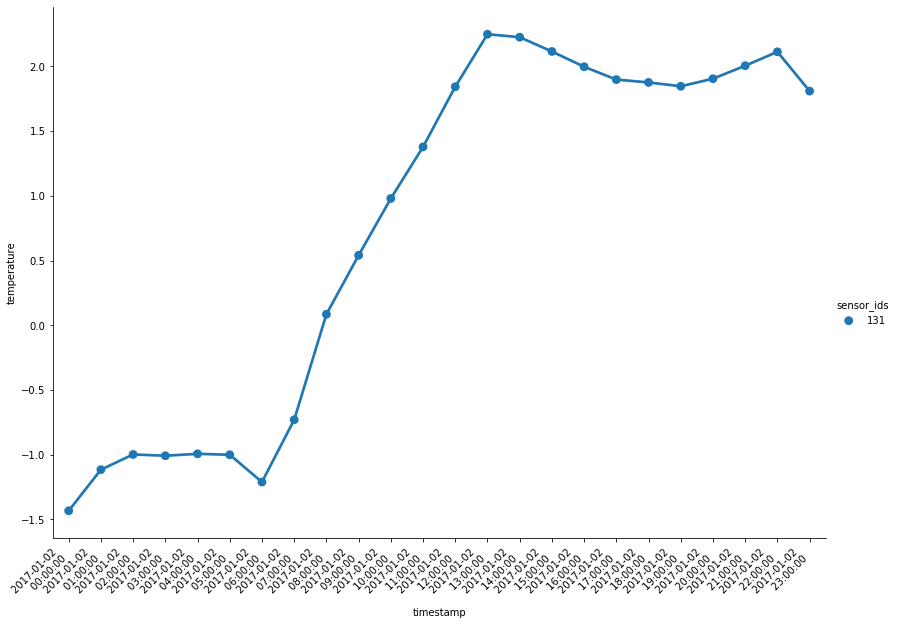

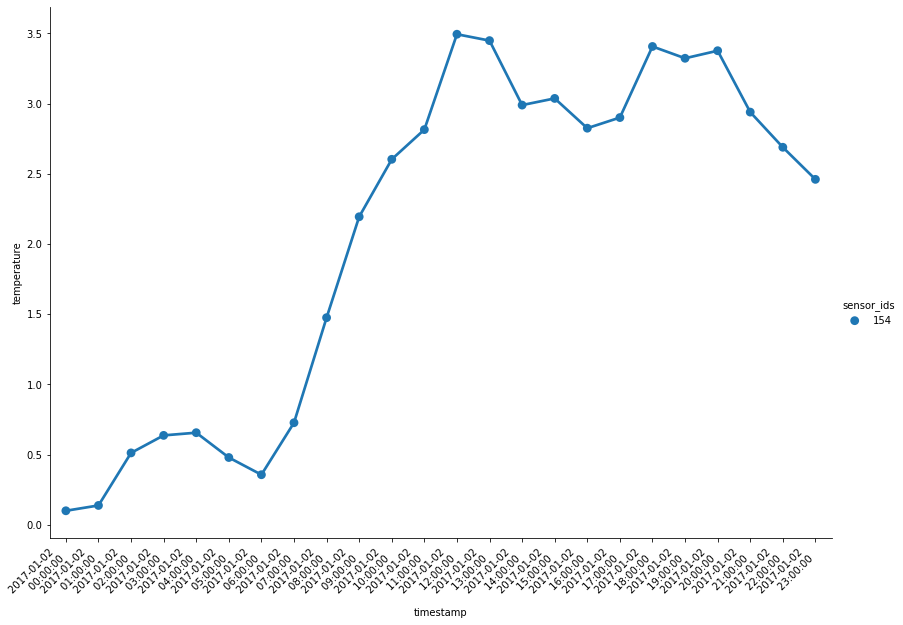

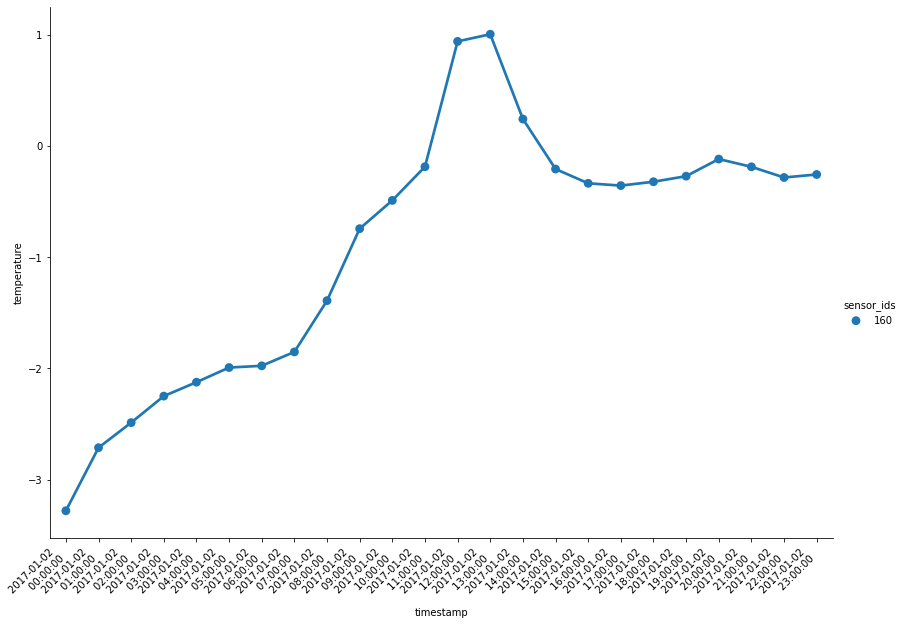

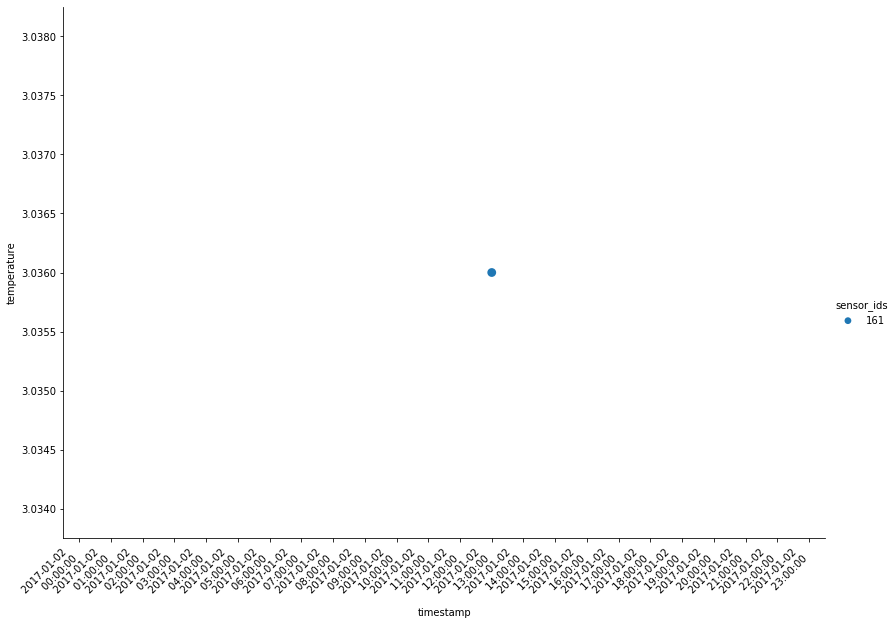

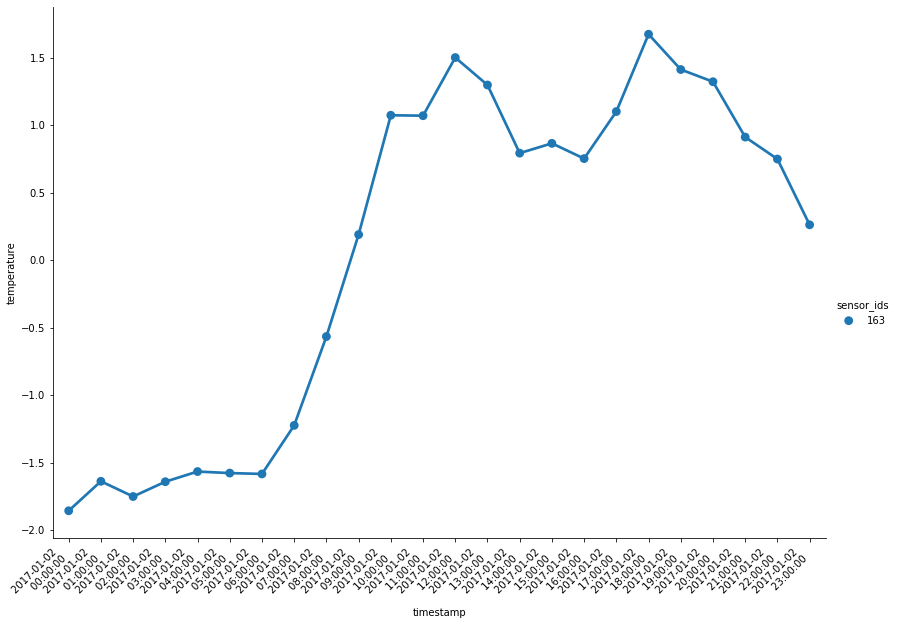

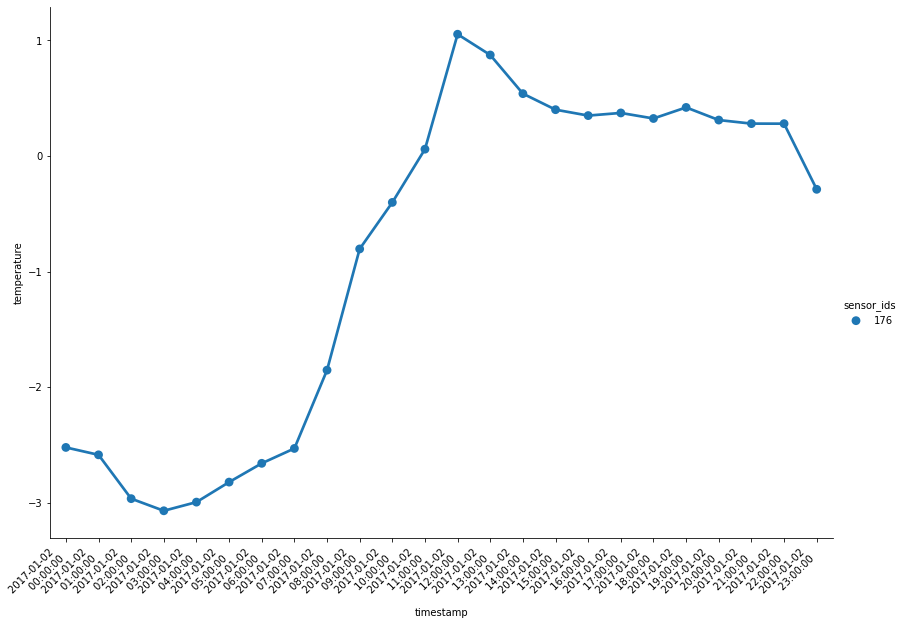

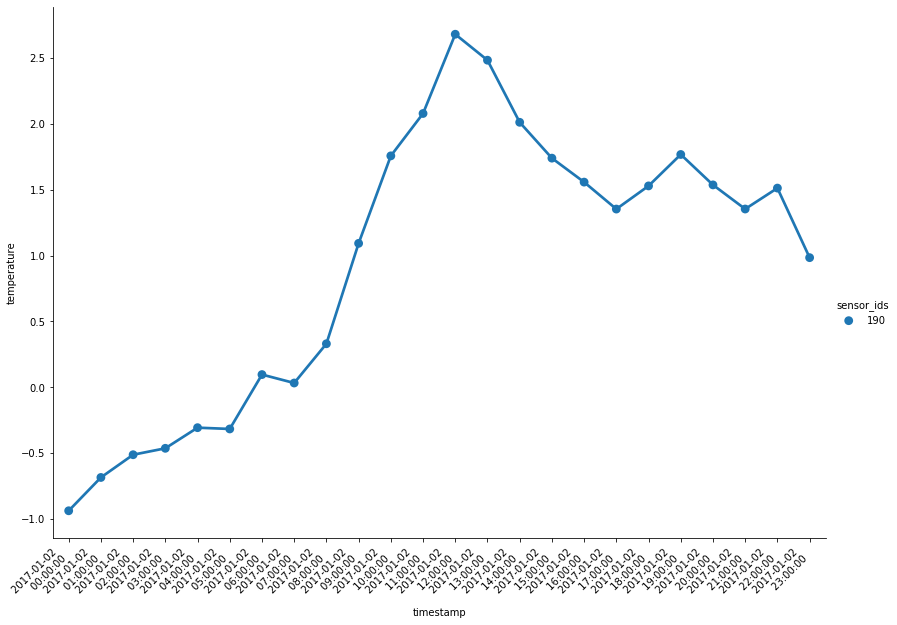

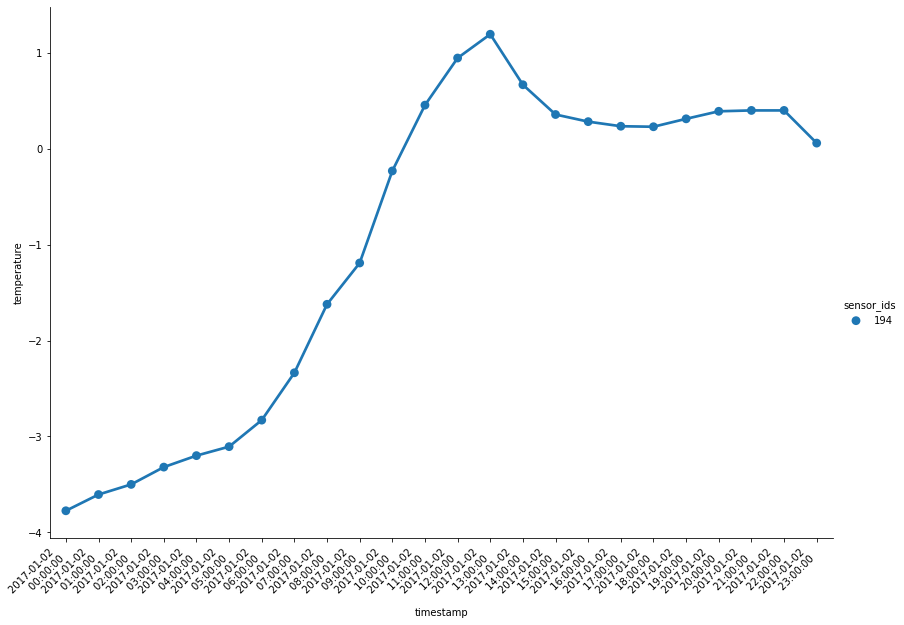

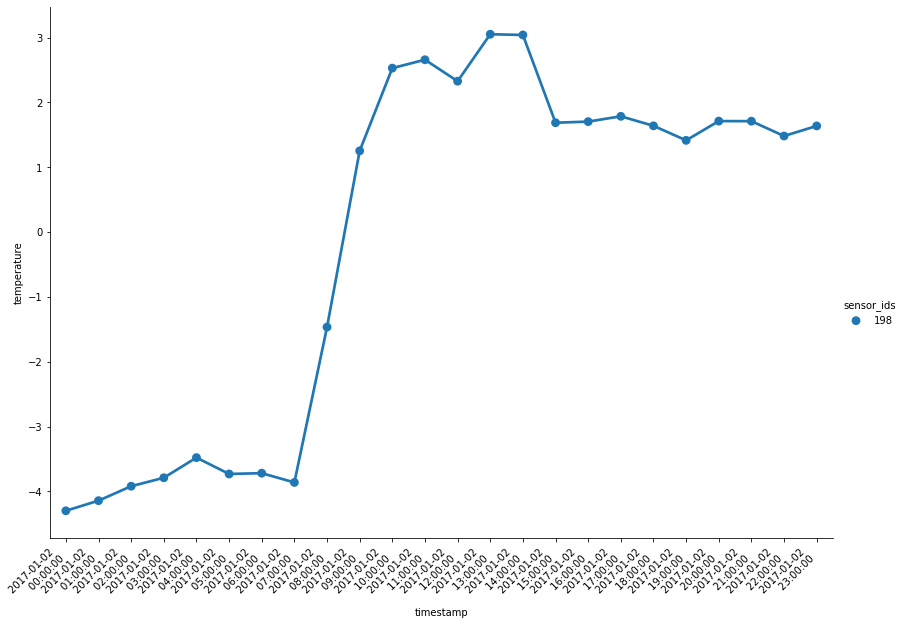

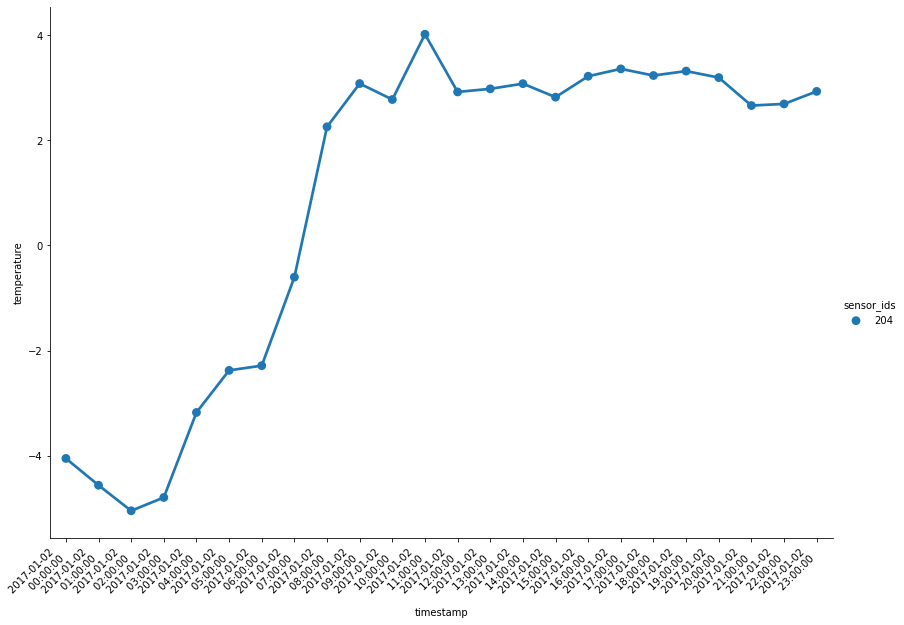

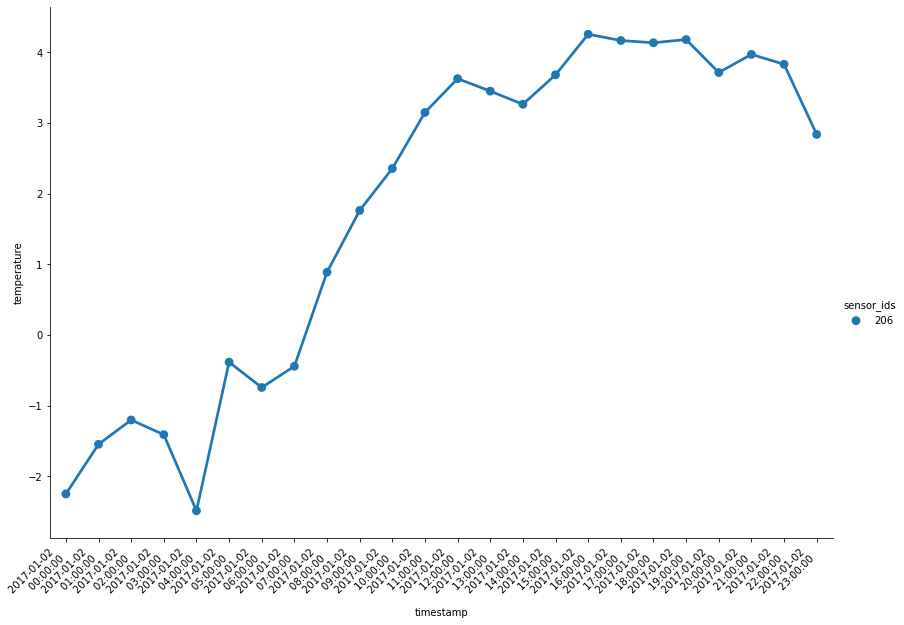

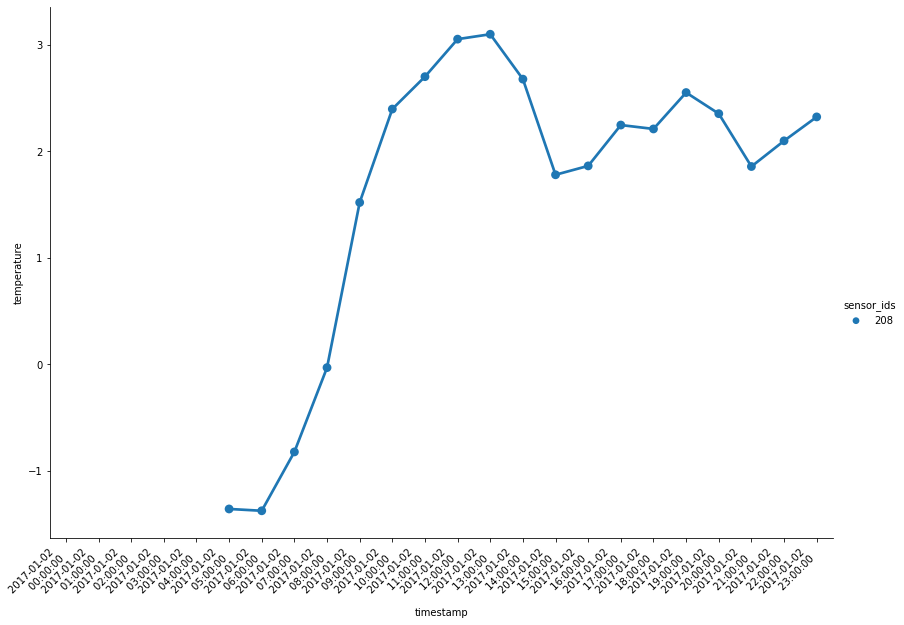

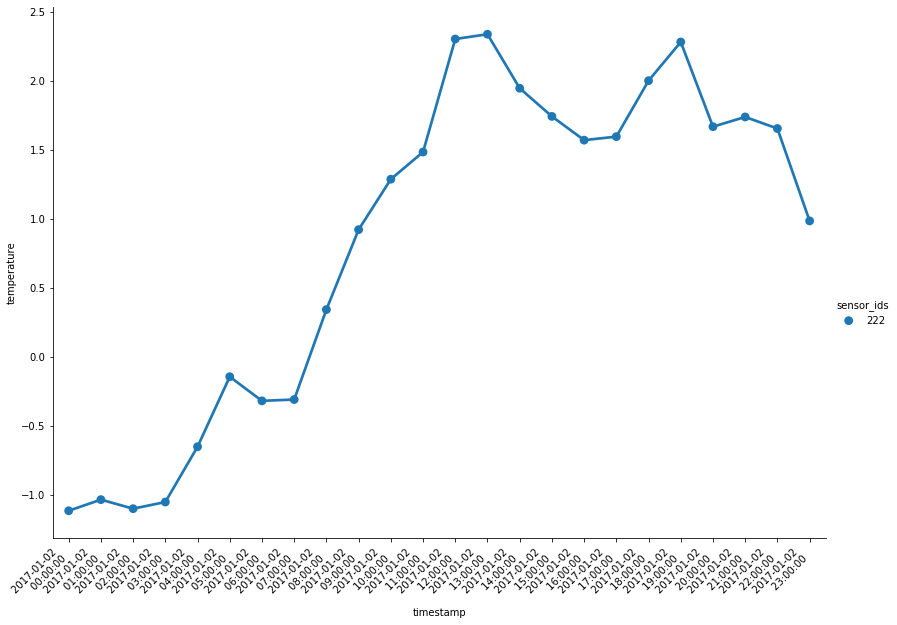

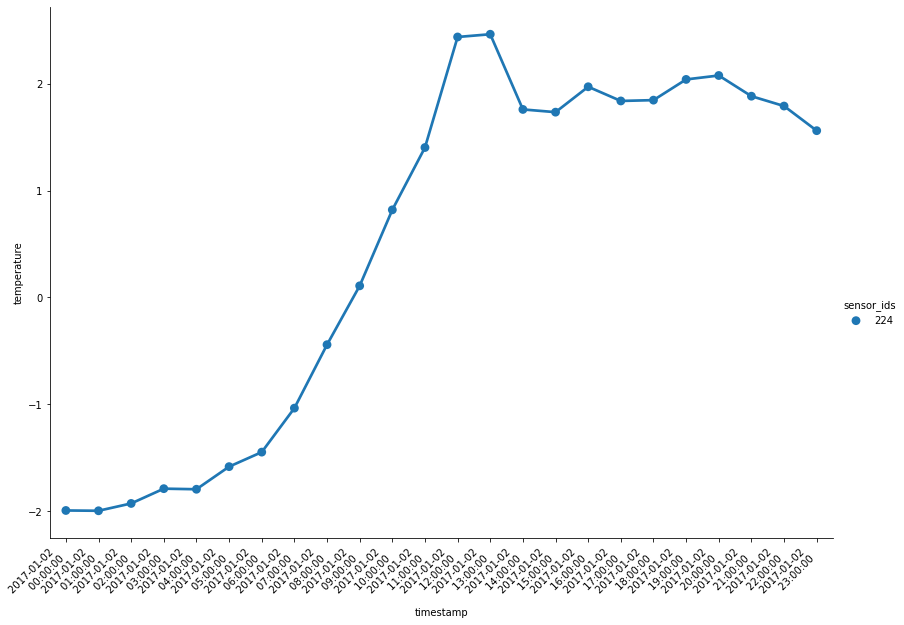

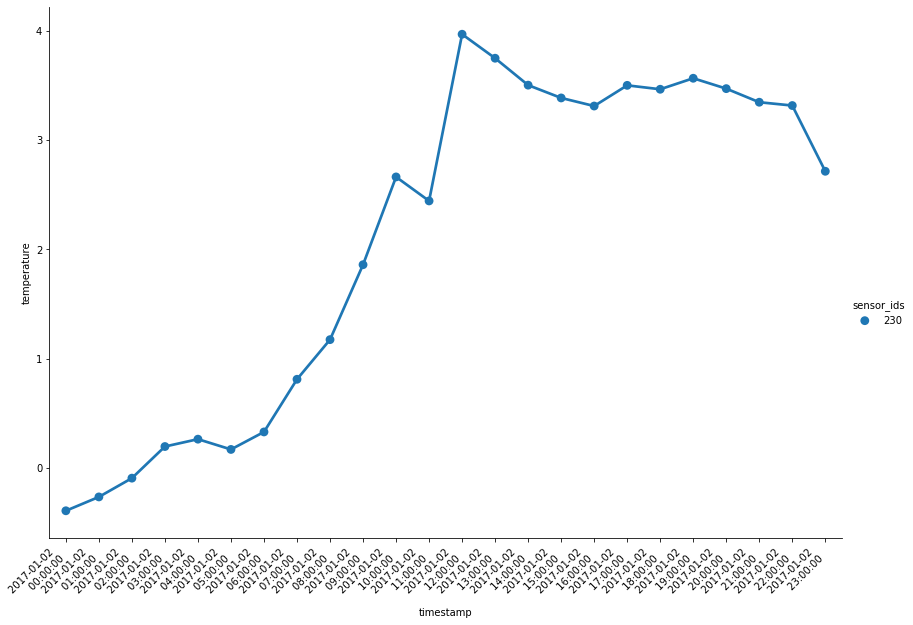

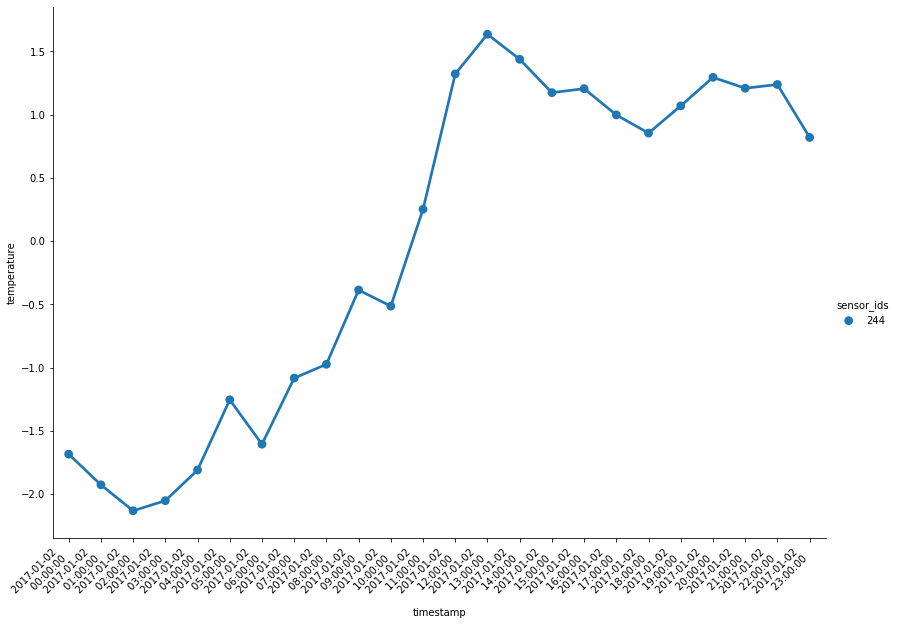

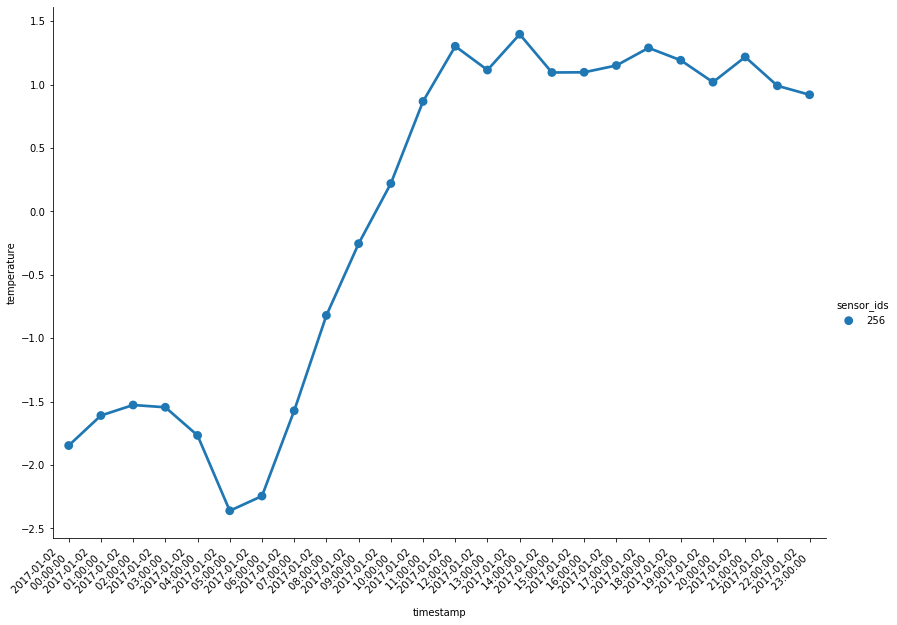

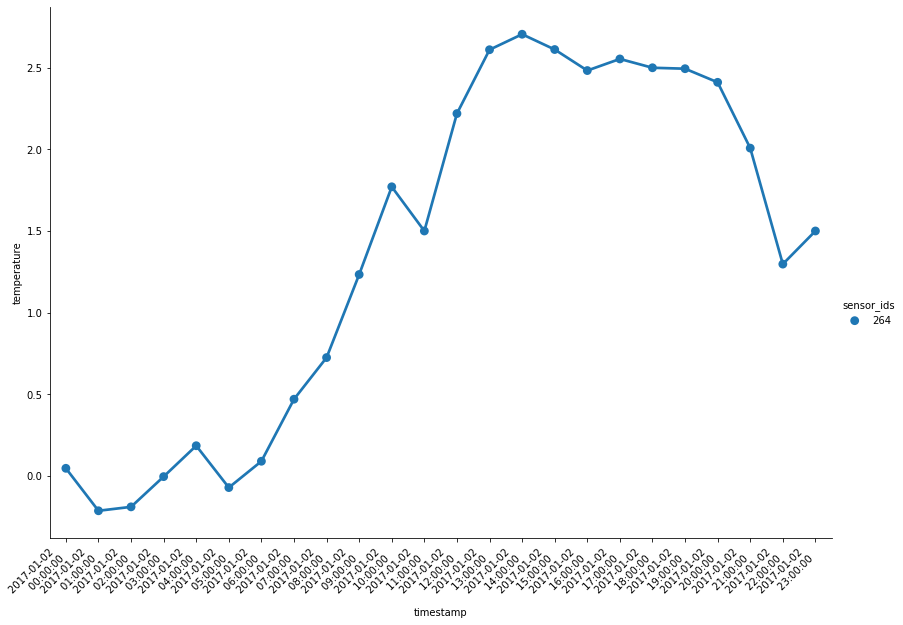

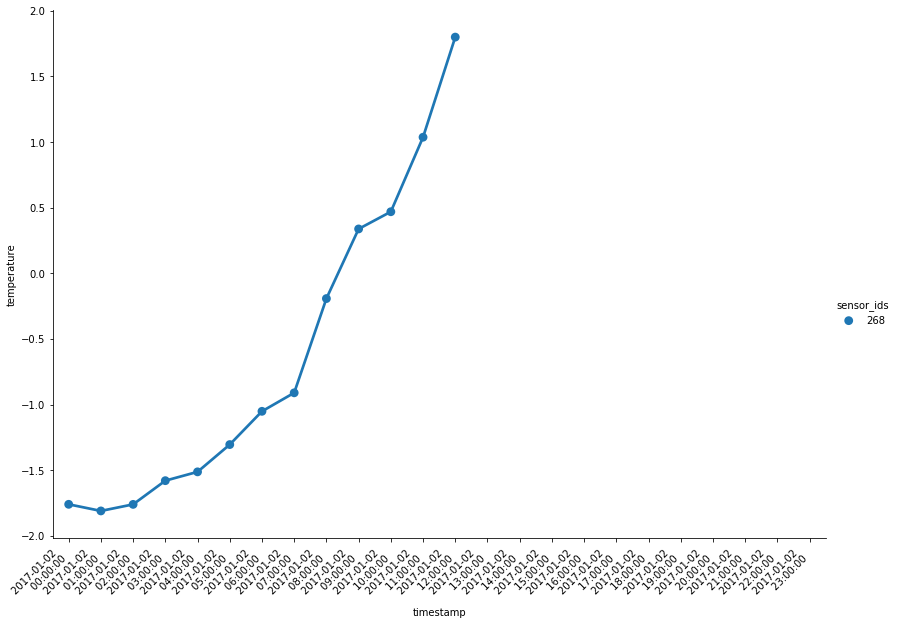

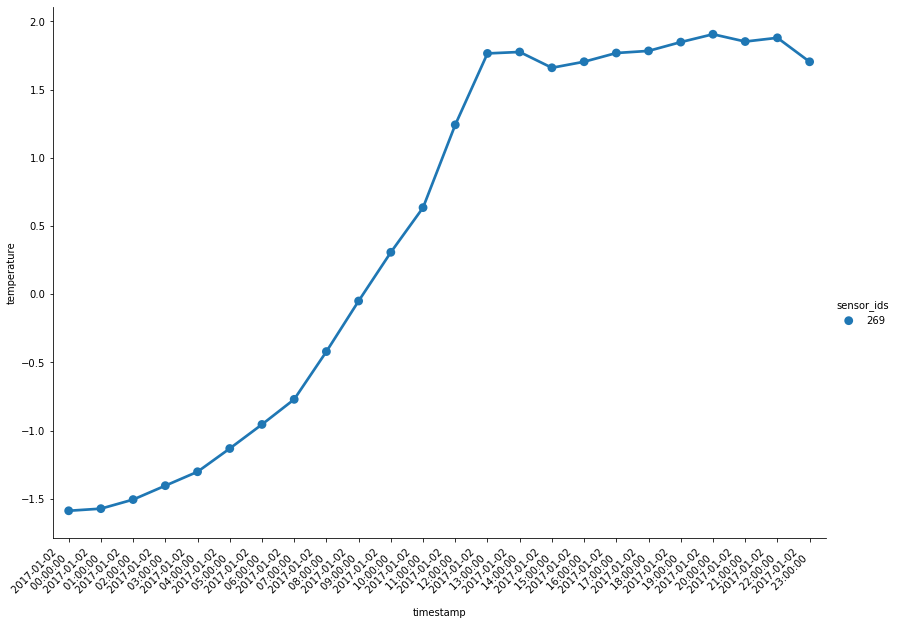

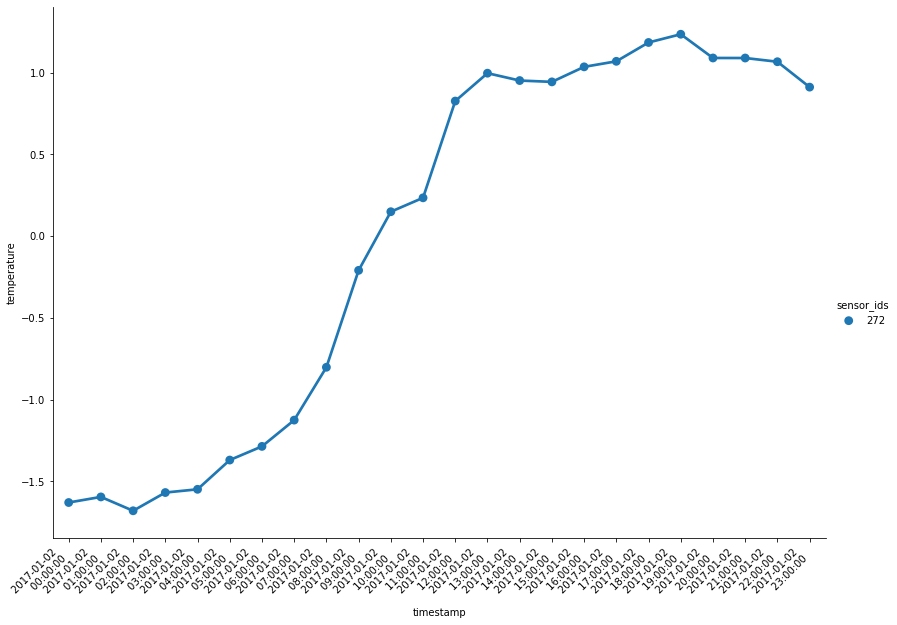

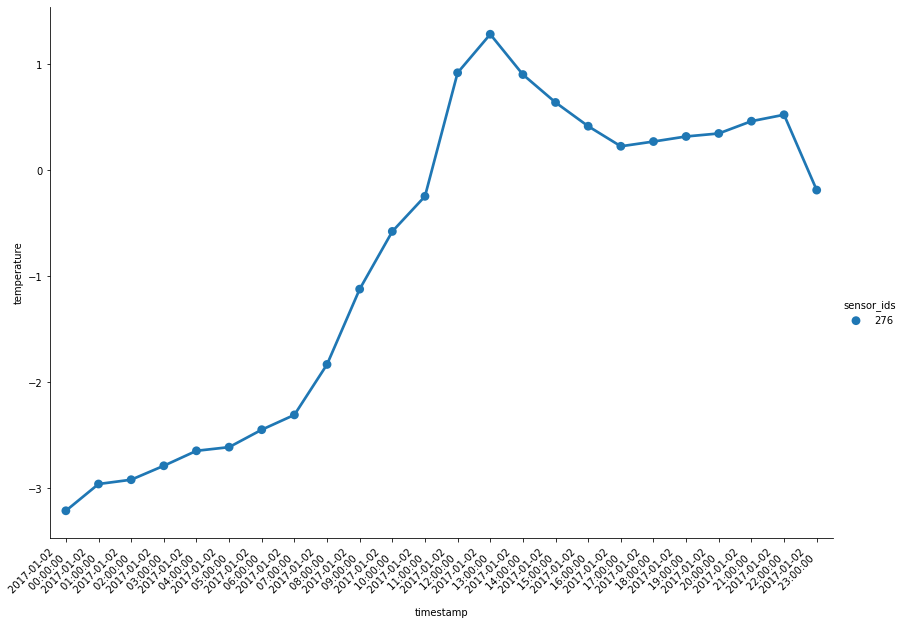

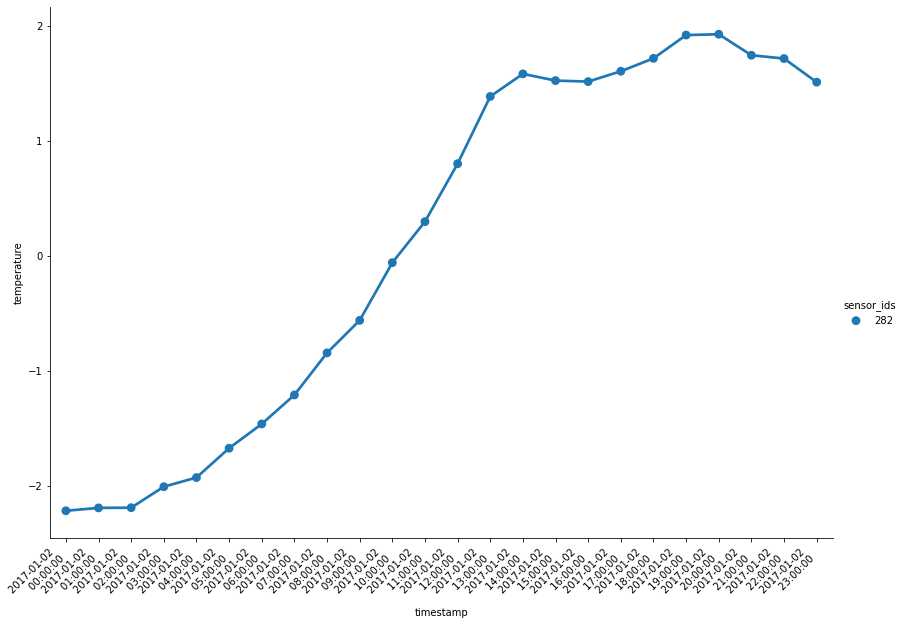

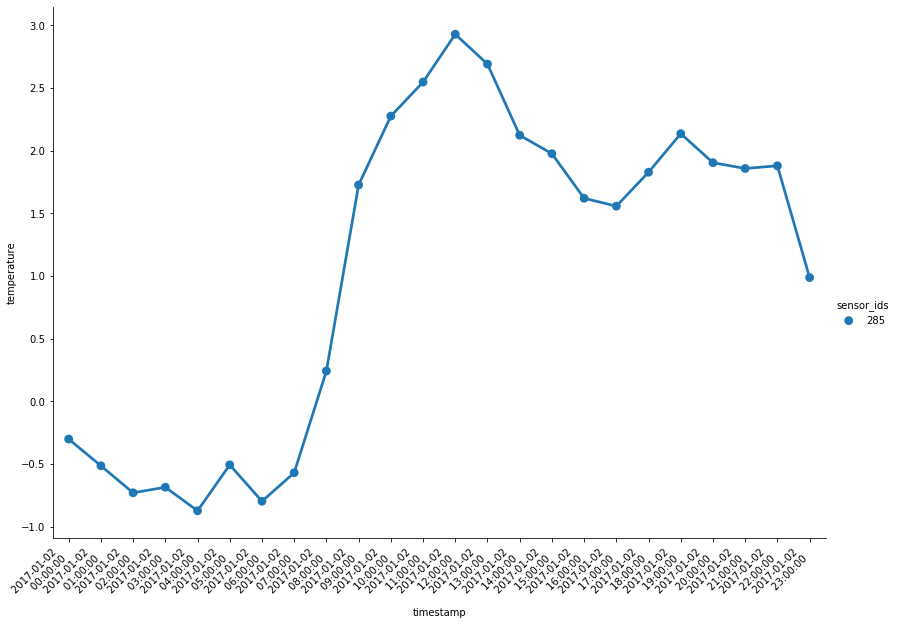

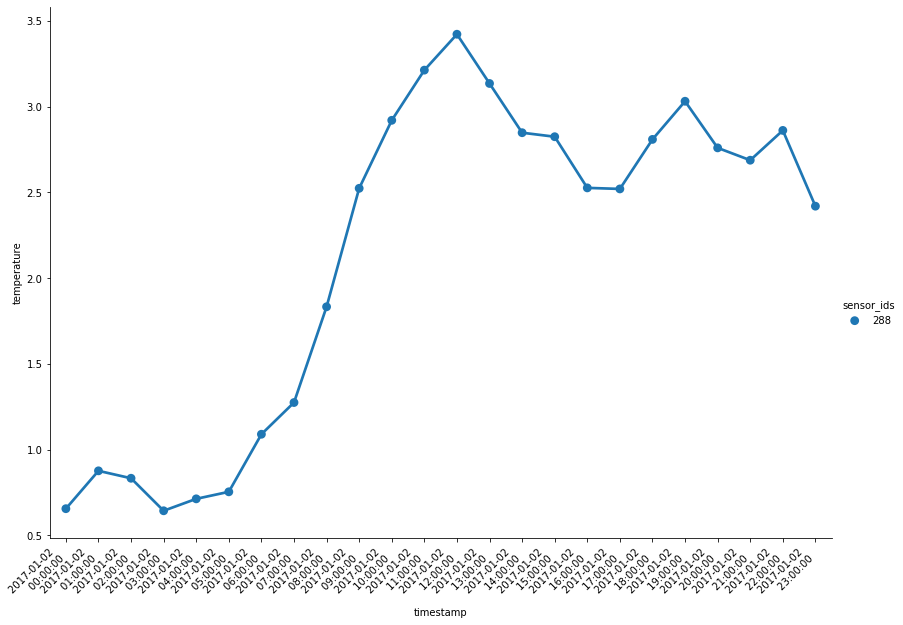

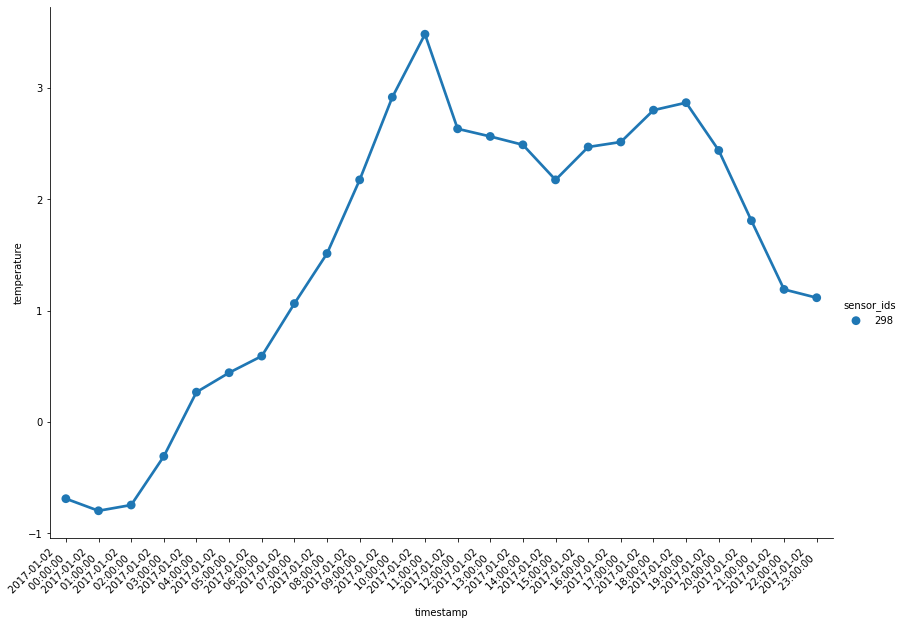

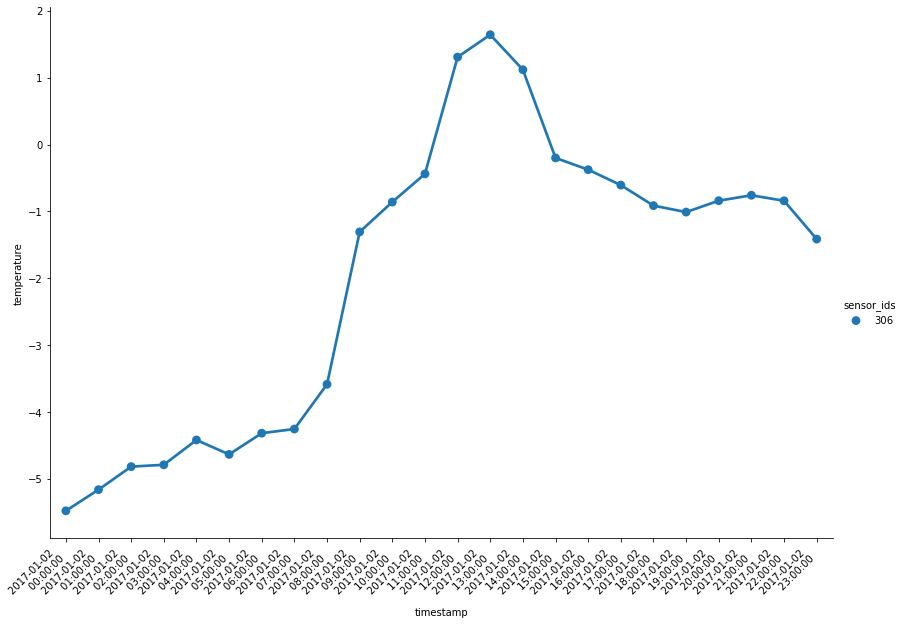

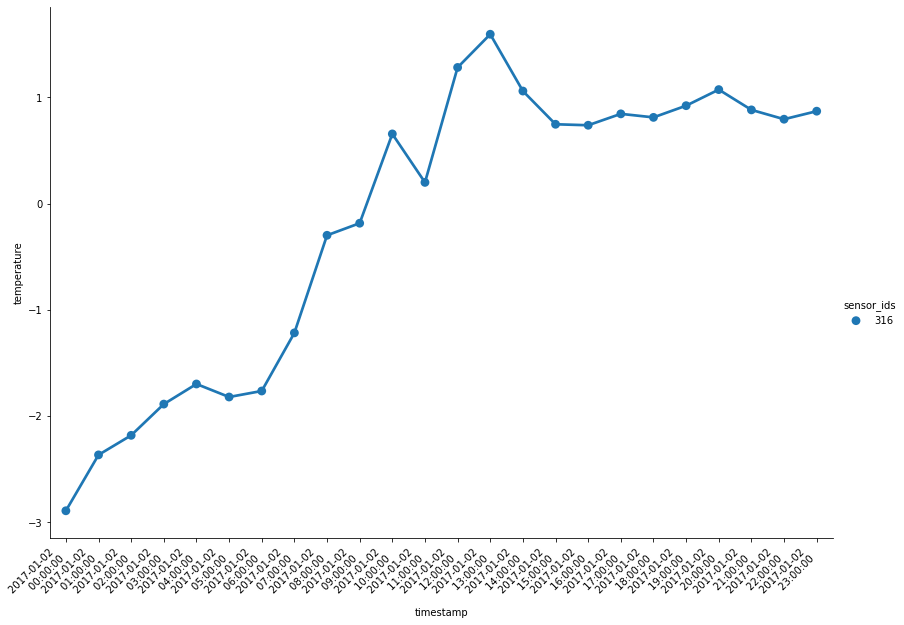

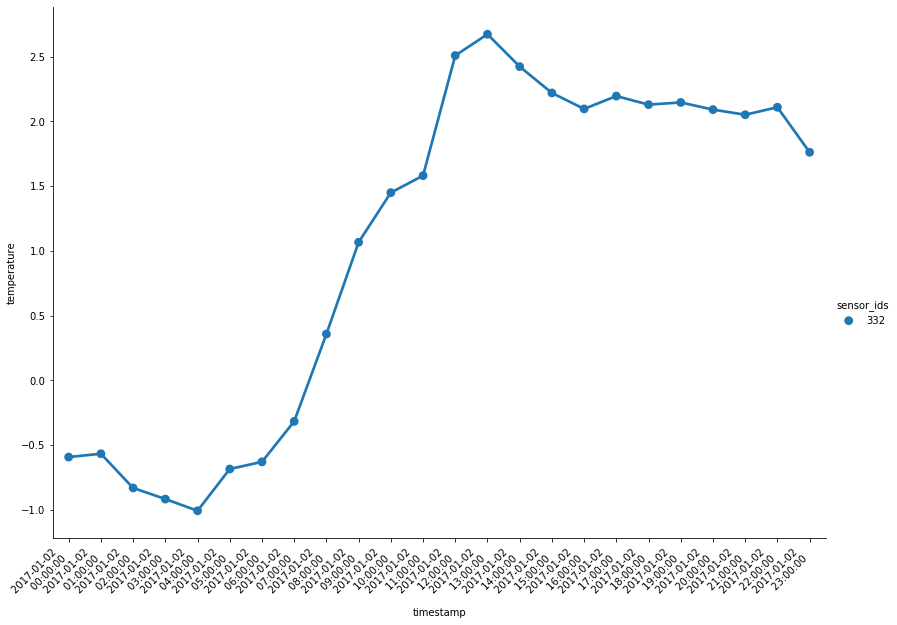

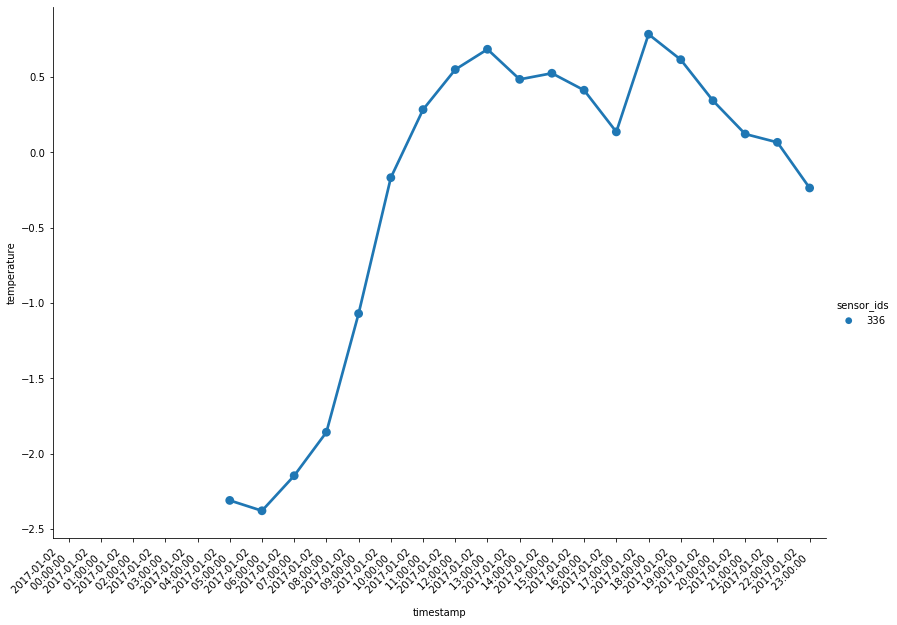

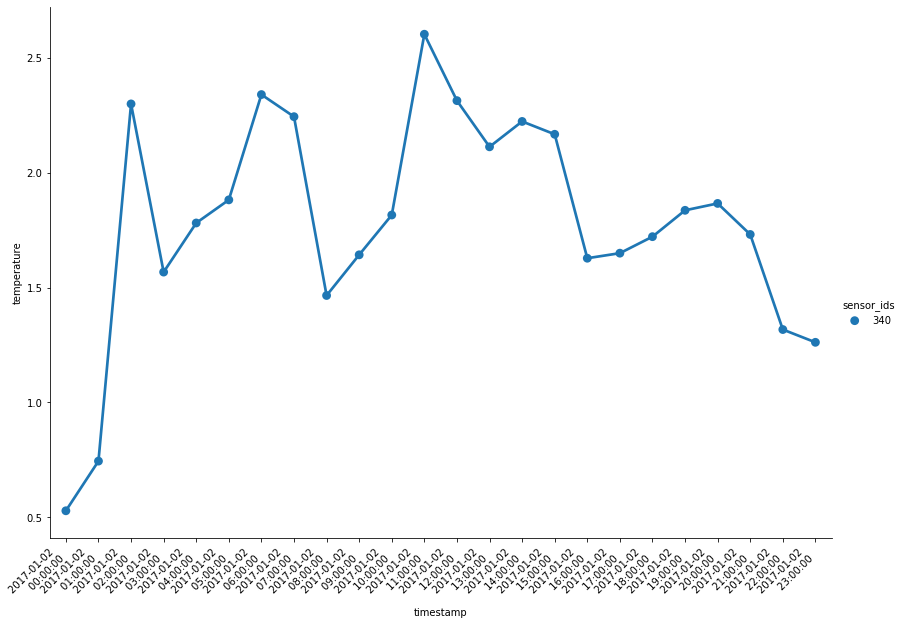

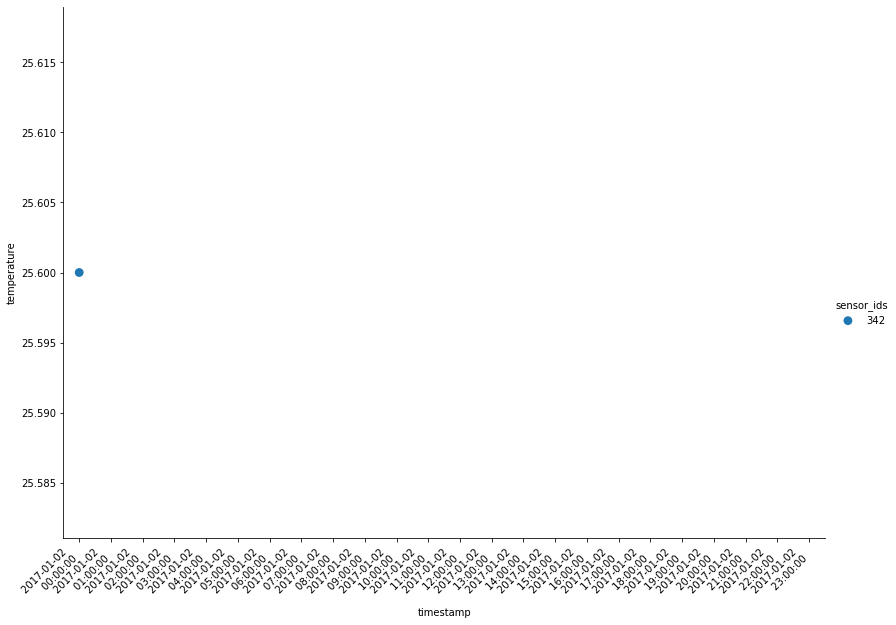

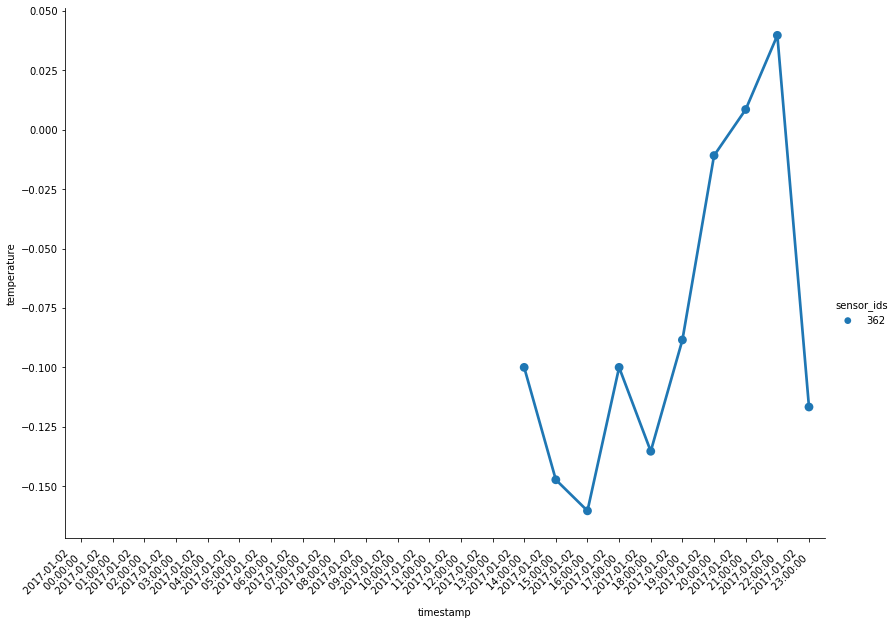

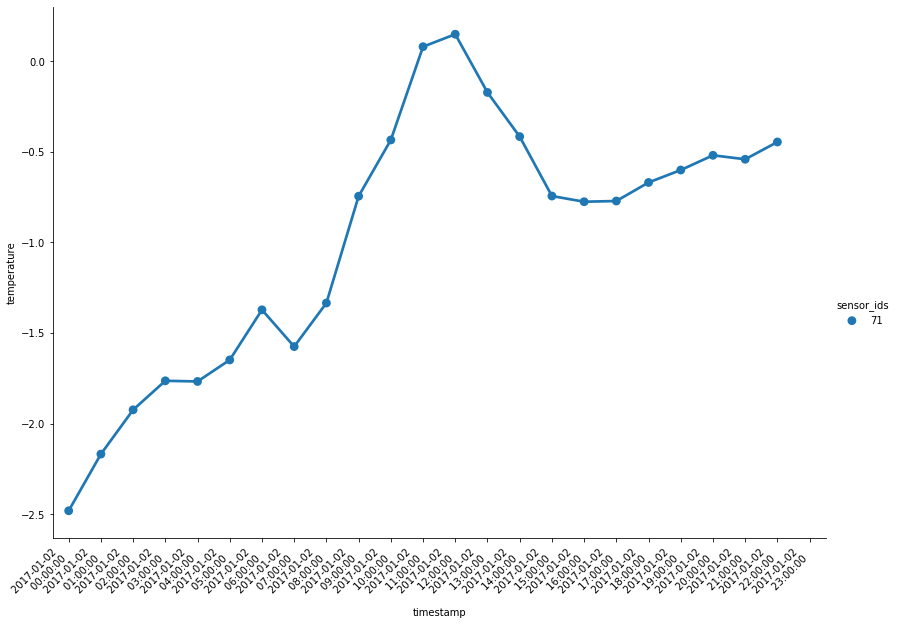

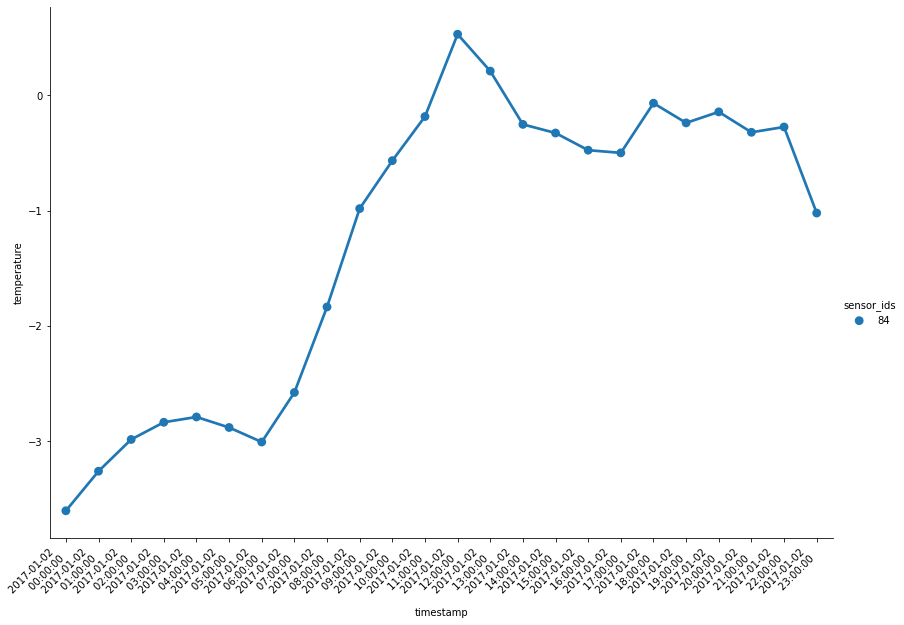

In [12]:
for i in range(0,len(appended_res_pd_frame_plot_timeindex.columns)):
    display(a[i])
    g = sns.catplot(x="timestamp", y=variable, hue='sensor_ids', kind="point", data=a[i], height=8.27, aspect=11.7/8.27)
    g.set_xticklabels(rotation=45, horizontalalignment='right')